In [16]:
# Cell 1 — Load cleaned data + metadata; identify authors and foils

import os
import re
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

PROJECT_ROOT = Path("../..").resolve()
CLEANED_CSV = PROJECT_ROOT / "data" / "processed" / "art_cleaned" / "ART_pretest_merged_EN_cleaned.csv"
ITEM_META_CSV = PROJECT_ROOT / "data" / "processed" / "art_cleaned" / "item_metadata.csv"
OUTPUT_DIR = PROJECT_ROOT / "data" / "processed" / "irt_art_results"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"CLEANED_CSV: {CLEANED_CSV}")
print(f"ITEM_META_CSV: {ITEM_META_CSV}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}\n")

raw = pd.read_csv(CLEANED_CSV, header=None, dtype=str)
labels = raw.iloc[0].tolist()
codes = raw.iloc[1].tolist()
data = raw.iloc[2:].reset_index(drop=True).copy()
data.columns = labels

meta = pd.read_csv(ITEM_META_CSV)

# Structure from prep notebook/cleaning decisions:
# first 5 cols = demographics, then 205 item cols, last col = source
demo_cols = labels[:5]
source_col = labels[-1]
item_labels = labels[5:-1]
item_codes = codes[5:-1]

if len(meta) != len(item_labels):
    raise ValueError(f"Metadata rows ({len(meta)}) != item columns ({len(item_labels)})")

if list(meta["item_label"].astype(str)) != [str(x) for x in item_labels]:
    raise ValueError("item_metadata item_label order does not match cleaned CSV item columns")

# Work on item block by position to avoid duplicate-label ambiguity.
item_block = data.iloc[:, 5:-1].copy()
item_block.columns = range(item_block.shape[1])
item_block = item_block.apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

# Robust genre extraction from code (e.g., cla12 -> cla, fill93 -> fill)
def extract_genre(code: str) -> str:
    s = re.sub(r"\s+", "", str(code).lower())
    m = re.match(r"([a-z]+)", s)
    return m.group(1) if m else "unknown"

meta = meta.copy()
meta["genre"] = meta["item_code"].astype(str).apply(extract_genre)

author_meta = meta[meta["is_real_author"]].copy()
foil_meta = meta[meta["is_foil"]].copy()
author_idx = author_meta["item_index"].astype(int).tolist()
foil_idx = foil_meta["item_index"].astype(int).tolist()

N = len(data)
print("=== Parsed dataset summary ===")
print(f"Rows incl. headers     : {raw.shape[0]}")
print(f"Participants (N)       : {N}")
print(f"Total columns          : {len(labels)}")
print(f"Demographic columns    : {demo_cols}")
print(f"Source column          : {source_col}")
print(f"Item columns           : {len(item_labels)}")
print(f"Authors (metadata)     : {len(author_idx)}")
print(f"Foils (metadata)       : {len(foil_idx)}")
print(f"Item labels aligned    : True")
print(f"Source waves found     : {sorted(data[source_col].astype(str).dropna().unique().tolist())}")
print(f"Genre tags found       : {sorted(meta['genre'].unique().tolist())}")
print("\nFirst 8 author items:")
print(author_meta[["item_index", "item_label", "item_code", "genre"]].head(8).to_string(index=False))
print("\nFirst 8 foil items:")
print(foil_meta[["item_index", "item_label", "item_code", "genre"]].head(8).to_string(index=False))

# Convenience maps used by later cells
meta_by_idx = meta.set_index("item_index")

PROJECT_ROOT: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor
CLEANED_CSV: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/art_cleaned/ART_pretest_merged_EN_cleaned.csv
ITEM_META_CSV: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/art_cleaned/item_metadata.csv
OUTPUT_DIR: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/irt_art_results

=== Parsed dataset summary ===
Rows incl. headers     : 1837
Participants (N)       : 1835
Total columns          : 211
Demographic columns    : ['Submited', 'age', 'sex ', 'humanities or not', 'education and profession']
Source column          : source
Item columns           : 205
Authors (metadata)     : 102
Foils (metadata)       : 103
Item labels aligned    : True
Source waves found     : ['ART_prestest_responses', 'pretest_EN']
Genre tags found       : ['cla', 'det', 'fan', 'fill', 'mod

In [17]:
# Cell 2 — Step 1: Descriptive statistics (Tables 1–3)

# Per-participant scores
hits = item_block.iloc[:, author_idx].sum(axis=1)
false_alarms = item_block.iloc[:, foil_idx].sum(axis=1)

data["hits"] = hits
data["false_alarms"] = false_alarms
data["standard_ART"] = data["hits"] - data["false_alarms"]
data["name_score"] = data["hits"]

# --- Table 1 (initial) ---
table1_rows = []
for label, col, nitems in [
    (f"Full {len(author_idx)}-author scale — Standard ART score", "standard_ART", len(author_idx)),
    (f"Full {len(author_idx)}-author scale — Name score", "name_score", len(author_idx)),
]:
    s = data[col]
    table1_rows.append({
        "Scale": label,
        "N items": nitems,
        "N": N,
        "M": round(s.mean(), 2),
        "SD": round(s.std(), 2),
        "Min": float(s.min()),
        "Max": float(s.max()),
        "Range": float(s.max() - s.min()),
        "Skew": round(s.skew(), 2),
    })

table1 = pd.DataFrame(table1_rows)
table1_path = OUTPUT_DIR / "descriptives_scores_basic.csv"
table1.to_csv(table1_path, index=False)

print("=" * 80)
print("TABLE 1 (initial) — Score summary")
print("=" * 80)
print(table1.to_string(index=False))
print(f"\nSaved: {table1_path}")

# --- Table 2 (selection rates only, IRT params added in Cell 4) ---
author_stats = author_meta[["item_index", "item_label", "item_code", "genre"]].copy()
author_stats["Percent Selected"] = [round(item_block.iloc[:, i].mean() * 100, 1) for i in author_stats["item_index"]]
author_stats = author_stats.rename(columns={
    "item_label": "Author Name",
    "item_code": "Item Code",
    "genre": "Genre",
}).sort_values("Percent Selected", ascending=False).reset_index(drop=True)
author_stats.index = author_stats.index + 1
author_stats.index.name = "Rank"

table2_sel_path = OUTPUT_DIR / "author_selection_rates.csv"
author_stats.to_csv(table2_sel_path)

print("\n" + "=" * 80)
print("TABLE 2 (pre-IRT) — Author selection rates")
print("=" * 80)
print(author_stats.head(20).to_string())
print(f"\nSaved: {table2_sel_path}")
print(f"Mean author selection rate: {author_stats['Percent Selected'].mean():.2f}%")
print(f"Easiest author: {author_stats.iloc[0]['Author Name']} ({author_stats.iloc[0]['Percent Selected']}%)")
print(f"Hardest author: {author_stats.iloc[-1]['Author Name']} ({author_stats.iloc[-1]['Percent Selected']}%)")

# --- Table 3 (foil selection: per-foil rates with foil names) ---
fa_counts = data["false_alarms"].value_counts().sort_index()
fa_dist = pd.DataFrame({
    "Errors": fa_counts.index,
    "N participants": fa_counts.values,
    "% of sample": [round(v / N * 100, 1) for v in fa_counts.values],
})

foil_rates = foil_meta[["item_index", "item_label", "item_code", "genre"]].copy()
foil_rates["Percent Selected"] = [round(item_block.iloc[:, i].mean() * 100, 1) for i in foil_rates["item_index"]]
foil_rates = foil_rates.rename(columns={"item_label": "Foil Name", "item_code": "Item Code", "genre": "Genre"})
foil_rates = foil_rates.sort_values("Percent Selected", ascending=False).reset_index(drop=True)

table3_path = OUTPUT_DIR / "foil_selection_rates.csv"
foil_rates.to_csv(table3_path, index=False)

print("\n" + "=" * 80)
print("TABLE 3 — False-alarm (foil selection) distribution")
print("=" * 80)
print(foil_rates.to_string(index=False))
print(f"\nSaved: {table3_path}")
print(f"Mean false alarms per participant: {data['false_alarms'].mean():.2f} (SD={data['false_alarms'].std():.2f})")
print(f"Participants with 0 false alarms: {(data['false_alarms'] == 0).sum()} ({(data['false_alarms'] == 0).mean() * 100:.1f}%)")
print("\nFalse-alarm count distribution (errors per participant):")
print(fa_dist.to_string(index=False))

TABLE 1 (initial) — Score summary
                                     Scale  N items    N     M   SD  Min   Max  Range  Skew
Full 102-author scale — Standard ART score      102 1835 39.08 20.7 -8.0  99.0  107.0  0.48
        Full 102-author scale — Name score      102 1835 47.72 20.1  1.0 101.0  100.0  0.12

Saved: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/irt_art_results/Table_1_initial.csv

TABLE 2 (pre-IRT) — Author selection rates
      item_index             Author Name Item Code Genre  Percent Selected
Rank                                                                      
1             40             Jack London      cla8   cla              97.4
2             85         Agatha Christie      det4   det              97.2
3             59      Arthur Conan Doyle     cla10   cla              97.1
4             84         Alexandre Dumas     cla14   cla              95.9
5            104            Ray Bradbury      sci2   sci   

In [18]:
# Cell 3 — Step 2: Dimensionality assessment (EFA)

# Compatibility shim for sklearn 1.6+ (ensure_all_finite) vs factor_analyzer (force_all_finite).
# Rerun-safe: restore sklearn.validation first, then patch only factor_analyzer's local symbol.
import importlib
import sklearn.utils.validation as _skl_val
_skl_val = importlib.reload(_skl_val)
_orig_check = _skl_val.check_array

def _check_array_compat(*args, **kwargs):
    fin = kwargs.pop("force_all_finite", kwargs.get("ensure_all_finite", True))
    kwargs["ensure_all_finite"] = fin
    return _orig_check(*args, **kwargs)

import factor_analyzer.factor_analyzer as _fa_mod
_fa_mod.check_array = _check_array_compat

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

X_authors = item_block.iloc[:, author_idx].values.astype(float)
# Ensure finite (factor_analyzer requires sklearn>=1.3 for check_array; no NaNs keeps analysis well-defined)
X_authors = np.nan_to_num(X_authors, nan=0.0, posinf=0.0, neginf=0.0)
author_labels = [meta_by_idx.loc[i, "item_label"] for i in author_idx]
author_genres = [meta_by_idx.loc[i, "genre"] for i in author_idx]

chi2, p_bart = calculate_bartlett_sphericity(X_authors)
kmo_all, kmo_model = calculate_kmo(X_authors)
print("Bartlett's test of sphericity:")
print(f"  chi2 = {chi2:.1f}, p = {p_bart:.4e}")
print(f"KMO sampling adequacy: {kmo_model:.3f}")

fa_init = FactorAnalyzer(
    n_factors=min(10, len(author_idx)),
    rotation=None,
    method="minres",
    is_corr_matrix=False,
)
fa_init.fit(X_authors)
ev, _ = fa_init.get_eigenvalues()

print("\nTop 10 eigenvalues:")
for i, e in enumerate(ev[:10], 1):
    print(f"  Factor {i:2d}: {e:6.2f}")

fa2 = FactorAnalyzer(n_factors=2, rotation="promax", method="minres", is_corr_matrix=False)
fa2.fit(X_authors)

loadings_all = pd.DataFrame(
    fa2.loadings_,
    index=author_idx,
    columns=["Factor_1", "Factor_2"],
)
loadings_all["Author Name"] = author_labels
loadings_all["Genre"] = author_genres
loadings_all["pct_selected"] = [item_block.iloc[:, i].mean() * 100 for i in author_idx]

f1_high = loadings_all[loadings_all["Factor_1"].abs() > 0.4]
f2_high = loadings_all[loadings_all["Factor_2"].abs() > 0.4]
mean_f1 = f1_high["pct_selected"].mean() if len(f1_high) else np.inf
mean_f2 = f2_high["pct_selected"].mean() if len(f2_high) else np.inf

guess_factor = "Factor_2" if mean_f2 <= mean_f1 else "Factor_1"
GUESS_LOAD_THRESH = 0.40
LOW_SELECT_THRESH = 10.0

guessing_items = loadings_all[
    (loadings_all[guess_factor].abs() > GUESS_LOAD_THRESH)
    & (loadings_all["pct_selected"] < LOW_SELECT_THRESH)
].index.tolist()

print("\n" + "=" * 80)
print("STEP 2 — Guessing-factor filtering")
print("=" * 80)
print(f"Guessing factor chosen: {guess_factor}")
print(f"Low-select threshold  : {LOW_SELECT_THRESH}%")
print(f"Load threshold        : {GUESS_LOAD_THRESH}")
print(f"Items flagged/removal : {len(guessing_items)}")
if guessing_items:
    cols_show = ["Author Name", "Genre", guess_factor, "pct_selected"]
    print(loadings_all.loc[guessing_items, cols_show].sort_values("pct_selected").round(3).to_string())

retained_author_idx = [i for i in author_idx if i not in guessing_items]
X_retained = item_block.iloc[:, retained_author_idx].values.astype(float)

fa2r = FactorAnalyzer(n_factors=2, rotation="promax", method="minres", is_corr_matrix=False)
fa2r.fit(X_retained)

loadings_ret = pd.DataFrame(
    fa2r.loadings_,
    index=retained_author_idx,
    columns=["Factor_1", "Factor_2"],
)
loadings_ret["Author Name"] = [meta_by_idx.loc[i, "item_label"] for i in retained_author_idx]
loadings_ret["Item Code"] = [meta_by_idx.loc[i, "item_code"] for i in retained_author_idx]
loadings_ret["Genre"] = [meta_by_idx.loc[i, "genre"] for i in retained_author_idx]
loadings_ret["pct_selected"] = [item_block.iloc[:, i].mean() * 100 for i in retained_author_idx]

phi = fa2r.phi_
factor_corr = float(phi[0, 1]) if phi is not None else np.nan

loadings_table = loadings_ret[["Author Name", "Item Code", "Genre", "pct_selected", "Factor_1", "Factor_2"]].copy()
loadings_table = loadings_table.sort_values("Factor_1", ascending=False)

table4_path = OUTPUT_DIR / "efa_factor_loadings.csv"
loadings_table.to_csv(table4_path, index=False)

fa1 = FactorAnalyzer(n_factors=1, rotation=None, method="minres", is_corr_matrix=False)
fa1.fit(X_retained)
var1 = fa1.get_factor_variance()
var2 = fa2r.get_factor_variance()

print("\n" + "=" * 80)
print(f"TABLE 4 — Two-factor loadings on retained items (n={len(retained_author_idx)})")
print("=" * 80)
print(loadings_table.head(25).round(3).to_string(index=False))
print(f"\nFactor intercorrelation: r = {factor_corr:.3f}")
print(f"1-factor cumulative variance explained: {var1[2][0] * 100:.2f}%")
print(f"2-factor cumulative variance explained: {var2[2][1] * 100:.2f}%")
print(f"Saved: {table4_path}")

print("\nTop 10 Factor_1 loaders:")
print(loadings_table.nlargest(10, "Factor_1")[["Author Name", "Genre", "Factor_1"]].round(3).to_string(index=False))
print("\nTop 10 Factor_2 loaders:")
print(loadings_table.nlargest(10, "Factor_2")[["Author Name", "Genre", "Factor_2"]].round(3).to_string(index=False))

Bartlett's test of sphericity:
  chi2 = 88020.9, p = 0.0000e+00
KMO sampling adequacy: 0.969

Top 10 eigenvalues:
  Factor  1:  22.18
  Factor  2:   9.88
  Factor  3:   3.54
  Factor  4:   3.19
  Factor  5:   2.39
  Factor  6:   2.15
  Factor  7:   1.79
  Factor  8:   1.61
  Factor  9:   1.40
  Factor 10:   1.31

STEP 2 — Guessing-factor filtering
Guessing factor chosen: Factor_2
Low-select threshold  : 10.0%
Load threshold        : 0.4
Items flagged/removal : 0

TABLE 4 — Two-factor loadings on retained items (n=102)
           Author Name Item Code Genre  pct_selected  Factor_1  Factor_2
     Michel Houlleback     mod24   mod        42.943     0.715    -0.278
     William Thackeray      cla7   cla        52.207     0.705    -0.001
      Somerset Maugham     cla14   cla        66.104     0.702     0.017
           John Fowles     cla11   cla        50.954     0.697     0.030
         Milorad Pavic     cla15   cla        33.951     0.678     0.040
           Isaac Babel     soc14   soc

TABLE 2 — Selection rates + 2PL parameters (n=102 retained authors)
                 Author Name Item Code Genre  Percent Selected  a (discrimination)  b (difficulty)
Rank                                                                                              
1                Jack London      cla8   cla              97.4               2.272          -2.492
2            Agatha Christie      det4   det              97.2               1.429          -3.100
3         Arthur Conan Doyle     cla10   cla              97.1               1.877          -2.648
4            Alexandre Dumas     cla14   cla              95.9               1.824          -2.441
5               Ray Bradbury      sci2   sci              95.6               2.251          -2.185
6          John R.R. Tolkien      fan3   fan              95.3               1.498          -2.608
7            Charles Dickens      cla7   cla              95.1               3.219          -1.897
8        Eric Maria Remarque     cla13   

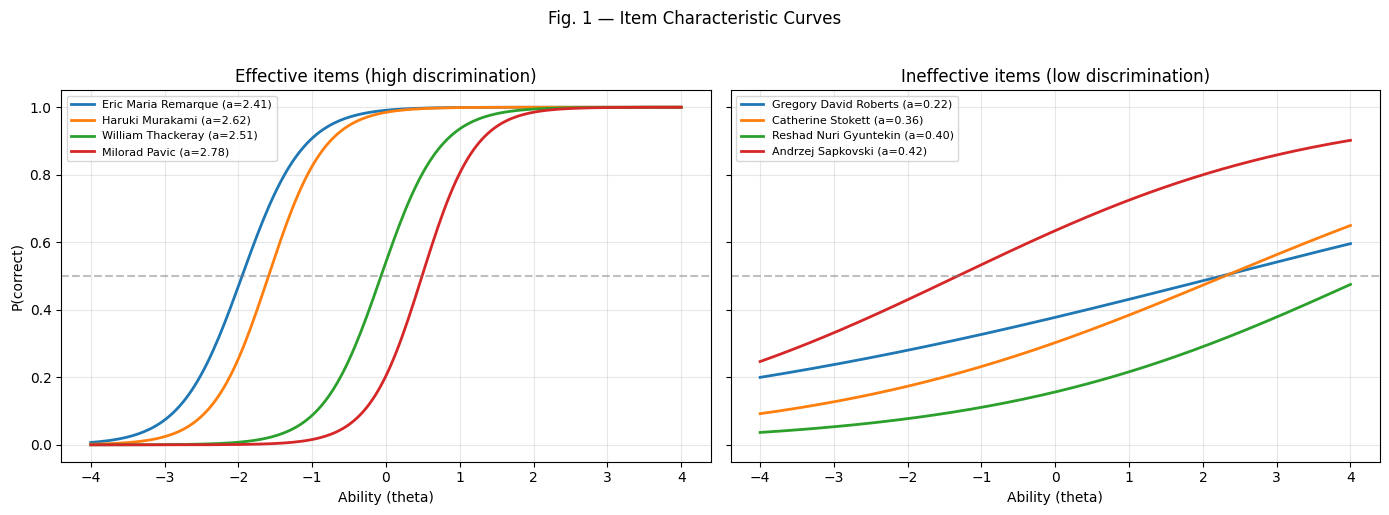

Saved: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/irt_art_results/Fig_1.png


In [19]:
# Cell 4 — Step 3: 2PL IRT model + Fig. 1

import matplotlib.pyplot as plt
from girth import twopl_mml

X_ret = item_block.iloc[:, retained_author_idx].values.astype(int)
estimates = twopl_mml(X_ret.T)

a_params = np.asarray(estimates["Discrimination"])
b_params = np.asarray(estimates["Difficulty"])

ret_labels = [meta_by_idx.loc[i, "item_label"] for i in retained_author_idx]
ret_codes = [meta_by_idx.loc[i, "item_code"] for i in retained_author_idx]
ret_genres = [meta_by_idx.loc[i, "genre"] for i in retained_author_idx]
ret_pct = [round(item_block.iloc[:, i].mean() * 100, 1) for i in retained_author_idx]

table2_irt = pd.DataFrame({
    "Author Name": ret_labels,
    "Item Code": ret_codes,
    "Genre": ret_genres,
    "Percent Selected": ret_pct,
    "a (discrimination)": np.round(a_params, 3),
    "b (difficulty)": np.round(b_params, 3),
})
table2_irt = table2_irt.sort_values("Percent Selected", ascending=False).reset_index(drop=True)
table2_irt.index = table2_irt.index + 1
table2_irt.index.name = "Rank"

table2_path = OUTPUT_DIR / "author_irt_parameters.csv"
table2_irt.to_csv(table2_path)

print("=" * 90)
print(f"TABLE 2 — Selection rates + 2PL parameters (n={len(retained_author_idx)} retained authors)")
print("=" * 90)
print(table2_irt.head(25).to_string())
print(f"\nSaved: {table2_path}")
print(f"\nDiscrimination (a): mean={a_params.mean():.3f}, sd={a_params.std():.3f}, range=[{a_params.min():.3f}, {a_params.max():.3f}]")
print(f"Difficulty (b): mean={b_params.mean():.3f}, sd={b_params.std():.3f}, range=[{b_params.min():.3f}, {b_params.max():.3f}]")

def icc(theta, a, b):
    return 1.0 / (1.0 + np.exp(-a * (theta - b)))

theta = np.linspace(-4, 4, 200)

high_a = table2_irt.nlargest(min(8, len(table2_irt)), "a (discrimination)").sort_values("b (difficulty)")
if len(high_a) >= 4:
    eff_idx = [high_a.index[0], high_a.index[len(high_a)//3], high_a.index[(2*len(high_a))//3], high_a.index[-1]]
else:
    eff_idx = high_a.index.tolist()
eff_items = high_a.loc[eff_idx].drop_duplicates(subset=["Author Name"]).head(4)
ineff_items = table2_irt.nsmallest(min(4, len(table2_irt)), "a (discrimination)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

ax = axes[0]
ax.set_title("Effective items (high discrimination)")
for _, row in eff_items.iterrows():
    y = icc(theta, row["a (discrimination)"], row["b (difficulty)"])
    ax.plot(theta, y, lw=2, label=f"{row['Author Name']} (a={row['a (discrimination)']:.2f})")
ax.set_xlabel("Ability (theta)")
ax.set_ylabel("P(correct)")
ax.axhline(0.5, color="gray", ls="--", alpha=0.5)
ax.grid(alpha=0.3)
ax.legend(fontsize=8)
ax.set_ylim(-0.05, 1.05)

ax = axes[1]
ax.set_title("Ineffective items (low discrimination)")
for _, row in ineff_items.iterrows():
    y = icc(theta, row["a (discrimination)"], row["b (difficulty)"])
    ax.plot(theta, y, lw=2, label=f"{row['Author Name']} (a={row['a (discrimination)']:.2f})")
ax.set_xlabel("Ability (theta)")
ax.axhline(0.5, color="gray", ls="--", alpha=0.5)
ax.grid(alpha=0.3)
ax.legend(fontsize=8)
ax.set_ylim(-0.05, 1.05)

plt.suptitle("Fig. 1 — Item Characteristic Curves", y=1.02)
plt.tight_layout()
fig1_path = OUTPUT_DIR / "fig_item_characteristic_curves.png"
plt.savefig(fig1_path, dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {fig1_path}")

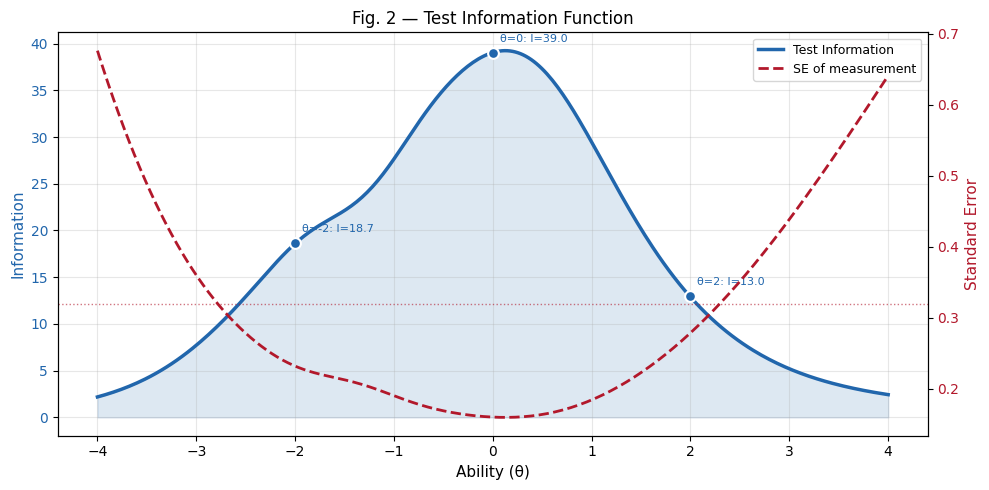

Saved: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/irt_art_results/Fig_2.png
Note: Dots mark reference points at θ = -2, 0, +2; dotted line indicates SE = 0.32 (reliability ≈ .90)

Peak information = 39.243 at theta = 0.120
Information at theta=-2: 18.668
Information at theta=+0: 38.999
Information at theta=+2: 12.958

Interpretation: test information is roughly centered around average ability.


In [20]:
# Cell 5 — Step 4: Test Information Function + Fig. 2

theta = np.linspace(-4, 4, 300)
item_info_matrix = np.zeros((len(retained_author_idx), len(theta)))

for j in range(len(retained_author_idx)):
    p = icc(theta, a_params[j], b_params[j])
    item_info_matrix[j, :] = (a_params[j] ** 2) * p * (1 - p)

tif = item_info_matrix.sum(axis=0)
sem = 1.0 / np.sqrt(np.clip(tif, 1e-9, None))

fig, ax1 = plt.subplots(figsize=(10, 5))
color_tif = "#2166ac"
color_sem = "#b2182b"

ax1.plot(theta, tif, color=color_tif, lw=2.5, label="Test Information")
ax1.fill_between(theta, tif, alpha=0.15, color=color_tif)
ax1.set_xlabel("Ability (θ)", fontsize=11)
ax1.set_ylabel("Information", color=color_tif, fontsize=11)
ax1.tick_params(axis="y", labelcolor=color_tif)
ax1.grid(alpha=0.3)

# Mark reference points on the curve with dots
ref_thetas = [-2, 0, 2]
ref_indices = [int(np.argmin(np.abs(theta - t))) for t in ref_thetas]
ref_info_vals = [tif[idx] for idx in ref_indices]
ax1.scatter(ref_thetas, ref_info_vals, color=color_tif, s=60, zorder=5, edgecolor="white", linewidth=1.5)

# Add text labels next to each reference point
for t, v in zip(ref_thetas, ref_info_vals):
    ax1.annotate(f"θ={t}: I={v:.1f}", xy=(t, v), xytext=(5, 8), textcoords="offset points",
                 fontsize=8, color=color_tif, ha="left")

ax2 = ax1.twinx()
ax2.plot(theta, sem, color=color_sem, lw=2, ls="--", label="SE of measurement")
ax2.set_ylabel("Standard Error", color=color_sem, fontsize=11)
ax2.tick_params(axis="y", labelcolor=color_sem)

# Add horizontal reference line at SE = 0.32 (reliability ≈ 0.90 threshold)
se_threshold = 0.32
ax2.axhline(se_threshold, color=color_sem, ls=":", alpha=0.6, lw=1)

ax1.set_title("Fig. 2 — Test Information Function", fontsize=12)

# Simplified legend with only curve labels
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=9)

plt.tight_layout()
fig2_path = OUTPUT_DIR / "fig_test_information_function.png"
plt.savefig(fig2_path, dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
print(f"Saved: {fig2_path}")
print("Note: Dots mark reference points at θ = -2, 0, +2; dotted line indicates SE = 0.32 (reliability ≈ .90)")

peak_theta = float(theta[np.argmax(tif)])
peak_info = float(tif.max())
print(f"\nPeak information = {peak_info:.3f} at theta = {peak_theta:.3f}")
for pt in (-2, 0, 2):
    idx = int(np.argmin(np.abs(theta - pt)))
    print(f"Information at theta={pt:+}: {tif[idx]:.3f}")

if peak_theta > 0.5:
    print("\nInterpretation: test is more informative at higher ability; consider adding easier items.")
elif peak_theta < -0.5:
    print("\nInterpretation: test is more informative at lower ability; consider adding harder items.")
else:
    print("\nInterpretation: test information is roughly centered around average ability.")

In [21]:
# Cell 6 — Step 5: Ability estimation (EAP) + scoring comparisons

from girth import ability_eap

theta_eap = ability_eap(X_ret.T, estimates["Difficulty"], estimates["Discrimination"])

author_sum_ret = item_block.iloc[:, retained_author_idx].sum(axis=1).astype(float)
mu_sum, sd_sum = float(author_sum_ret.mean()), float(author_sum_ret.std())
mu_eap, sd_eap = float(theta_eap.mean()), float(theta_eap.std())

if sd_eap == 0:
    raise ValueError("EAP SD is zero; cannot rescale ability estimates.")

eap_rescaled = (theta_eap - mu_eap) / sd_eap * sd_sum + mu_sum
fa = data["false_alarms"].astype(float).values

data["standard_ART_ret"] = author_sum_ret - fa
data["name_score_ret"] = author_sum_ret
data["IRT_no_penalty"] = eap_rescaled
data["IRT_minus1"] = eap_rescaled - 1 * fa
data["IRT_minus2"] = eap_rescaled - 2 * fa

score_cols_info = [
    (f"Full {len(author_idx)}-author — Standard ART", "standard_ART", len(author_idx)),
    (f"Full {len(author_idx)}-author — Name score", "name_score", len(author_idx)),
    (f"Retained {len(retained_author_idx)}-author — Standard ART", "standard_ART_ret", len(retained_author_idx)),
    (f"Retained {len(retained_author_idx)}-author — Name score", "name_score_ret", len(retained_author_idx)),
    (f"Retained {len(retained_author_idx)}-author — IRT (no penalty)", "IRT_no_penalty", len(retained_author_idx)),
    (f"Retained {len(retained_author_idx)}-author — IRT (-1 x errors)", "IRT_minus1", len(retained_author_idx)),
    (f"Retained {len(retained_author_idx)}-author — IRT (-2 x errors)", "IRT_minus2", len(retained_author_idx)),
]

rows = []
for label, col, ni in score_cols_info:
    s = data[col]
    rows.append({
        "Scale": label,
        "N items": ni,
        "N": N,
        "M": round(float(s.mean()), 2),
        "SD": round(float(s.std()), 2),
        "Min": round(float(s.min()), 2),
        "Max": round(float(s.max()), 2),
        "Range": round(float(s.max() - s.min()), 2),
        "Skew": round(float(s.skew()), 2),
    })

table1_ext = pd.DataFrame(rows)
table1_final_path = OUTPUT_DIR / "descriptives_scores_all_methods.csv"
table1_ext.to_csv(table1_final_path, index=False)

print("=" * 95)
print("TABLE 1 (extended) — All scoring methods")
print("=" * 95)
print(table1_ext.to_string(index=False))
print(f"\nSaved: {table1_final_path}")

score_keys = ["standard_ART_ret", "name_score_ret", "IRT_no_penalty", "IRT_minus1", "IRT_minus2"]
corr_matrix = data[score_keys].corr().round(3)
print("\nCorrelations among retained-item scoring methods:")
print(corr_matrix.to_string())

participant_scores = pd.DataFrame({
    "participant_id": np.arange(1, N + 1),
    "source": data[source_col].astype(str).values,
    "hits": data["hits"].values,
    "false_alarms": data["false_alarms"].values,
    "standard_ART": data["standard_ART"].values,
    "name_score": data["name_score"].values,
    "standard_ART_ret": data["standard_ART_ret"].values,
    "name_score_ret": data["name_score_ret"].values,
    "IRT_no_penalty": data["IRT_no_penalty"].values,
    "IRT_minus1": data["IRT_minus1"].values,
    "IRT_minus2": data["IRT_minus2"].values,
})

participant_scores_path = OUTPUT_DIR / "participant_scores.csv"
participant_scores.to_csv(participant_scores_path, index=False)
print(f"Saved: {participant_scores_path}")

TABLE 1 (extended) — All scoring methods
                                  Scale  N items    N     M    SD    Min    Max  Range  Skew
         Full 102-author — Standard ART      102 1835 39.08 20.70  -8.00  99.00 107.00  0.48
           Full 102-author — Name score      102 1835 47.72 20.10   1.00 101.00 100.00  0.12
     Retained 102-author — Standard ART      102 1835 39.08 20.70  -8.00  99.00 107.00  0.48
       Retained 102-author — Name score      102 1835 47.72 20.10   1.00 101.00 100.00  0.12
 Retained 102-author — IRT (no penalty)      102 1835 47.72 20.10 -20.69 124.72 145.41  0.14
Retained 102-author — IRT (-1 x errors)      102 1835 39.08 20.94 -20.69 115.97 136.67  0.52
Retained 102-author — IRT (-2 x errors)      102 1835 30.44 25.25 -81.75 114.97 196.72  0.15

Saved: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/irt_art_results/Table_1.csv

Correlations among retained-item scoring methods:
                  standard_ART_ret 

## Short-scale analysis (Step 8)

Select a subset of items that retain good psychometric properties (high discrimination, coverage across difficulty) for a shorter scale (e.g. screening or time-limited assessment). Compare test information of the full vs short scale.

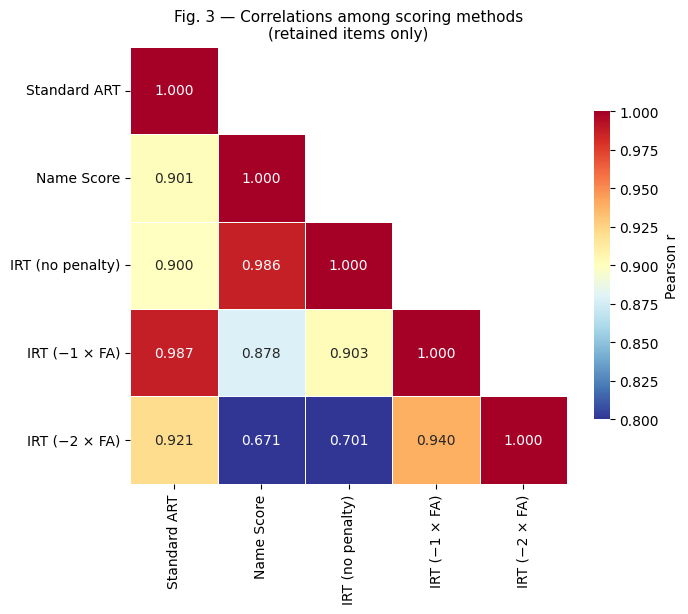

Saved: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/irt_art_results/Fig_3_score_correlations.png

All pairwise correlations ≥ 0.671
Interpretation: Scoring methods are highly correlated; IRT-based scores with FA penalties
show slightly lower correlations with name-only scores, as expected.


In [22]:
# Correlation matrix heatmap — scoring methods comparison
import seaborn as sns

# Recalculate correlation matrix with cleaner labels
score_labels_map = {
    "standard_ART_ret": "Standard ART",
    "name_score_ret": "Name Score",
    "IRT_no_penalty": "IRT (no penalty)",
    "IRT_minus1": "IRT (−1 × FA)",
    "IRT_minus2": "IRT (−2 × FA)",
}
corr_df = data[score_keys].rename(columns=score_labels_map).corr()

fig, ax = plt.subplots(figsize=(7, 6))
mask = np.triu(np.ones_like(corr_df, dtype=bool), k=1)  # upper triangle mask

sns.heatmap(
    corr_df,
    mask=mask,
    annot=True,
    fmt=".3f",
    cmap="RdYlBu_r",
    vmin=0.8,
    vmax=1.0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.7, "label": "Pearson r"},
    ax=ax,
)
ax.set_title("Fig. 3 — Correlations among scoring methods\n(retained items only)", fontsize=11)
plt.tight_layout()

fig3_path = OUTPUT_DIR / "fig_score_method_correlations.png"
fig.savefig(fig3_path, dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
print(f"Saved: {fig3_path}")

# Summary interpretation
min_r = corr_df.values[~mask].min()
print(f"\nAll pairwise correlations ≥ {min_r:.3f}")
print("Interpretation: Scoring methods are highly correlated; IRT-based scores with FA penalties")
print("show slightly lower correlations with name-only scores, as expected.")

In [23]:
# Step 8: Short-scale selection (top 60% discrimination, difficulty coverage)
def item_information_2pl(theta_arr, a, b):
    p = icc(theta_arr, a, b)
    return (a ** 2) * p * (1 - p)

irt_params = pd.DataFrame({
    "item": retained_author_idx,
    "Author Name": ret_labels,
    "discrimination_a": a_params,
    "difficulty_b": b_params,
    "endorsement_rate": np.array(ret_pct) / 100.0,
})

disc_threshold_percentile = 40
disc_threshold = np.percentile(irt_params["discrimination_a"], disc_threshold_percentile)
short_scale_mask = irt_params["discrimination_a"] >= disc_threshold
short_scale_items = irt_params[short_scale_mask].copy()
n_short = len(short_scale_items)

print("Step 8 — Short-scale selection")
print(f"  Discrimination threshold (top 60%): a >= {disc_threshold:.3f}")
print(f"  Items selected for short scale: {n_short} (from {len(irt_params)} total)")
print("\n  Difficulty coverage (full vs short):")
difficulty_bins = [(-np.inf, -2), (-2, -1), (-1, 0), (0, 1), (1, 2), (2, np.inf)]
bin_labels = ["Very Easy", "Easy", "Medium-Easy", "Medium-Hard", "Hard", "Very Hard"]
for (low, high), label in zip(difficulty_bins, bin_labels):
    full_c = ((irt_params["difficulty_b"] >= low) & (irt_params["difficulty_b"] < high)).sum()
    short_c = ((short_scale_items["difficulty_b"] >= low) & (short_scale_items["difficulty_b"] < high)).sum()
    print(f"    {label} (b in [{low}, {high})): Full={full_c}, Short={short_c}")

Step 8 — Short-scale selection
  Discrimination threshold (top 60%): a >= 1.306
  Items selected for short scale: 61 (from 102 total)

  Difficulty coverage (full vs short):
    Very Easy (b in [-inf, -2)): Full=7, Short=6
    Easy (b in [-2, -1)): Full=10, Short=7
    Medium-Easy (b in [-1, 0)): Full=24, Short=18
    Medium-Hard (b in [0, 1)): Full=38, Short=27
    Hard (b in [1, 2)): Full=11, Short=3
    Very Hard (b in [2, inf)): Full=12, Short=0


  Info retained: 77.4%
  Full peak θ = 0.120, Short peak θ = 0.094


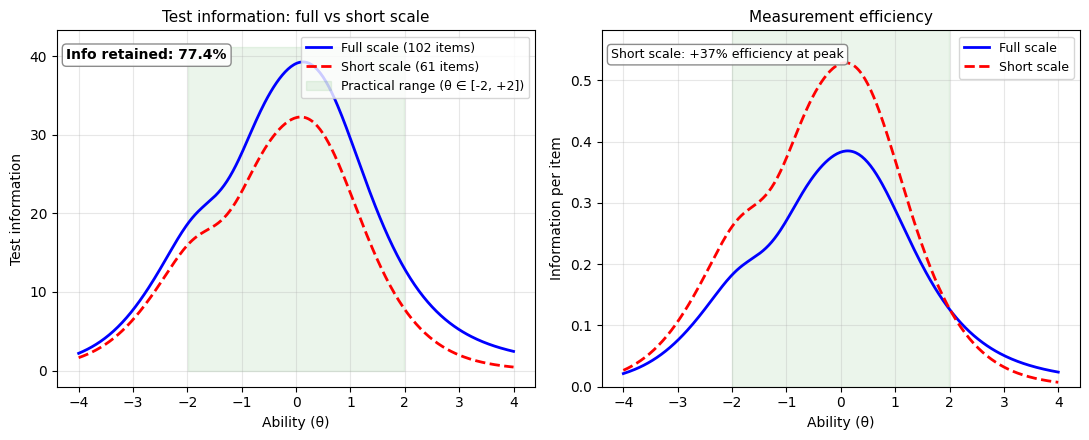

Saved: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/irt_art_results/short_vs_full_tif.png
Saved: short_scale_candidates.csv
Saved: short_scale_info_comparison.csv


In [24]:
# Step 8: TIF comparison (full vs short) and save outputs
short_info = np.zeros_like(theta)
for _, row in short_scale_items.iterrows():
    short_info += item_information_2pl(theta, row["discrimination_a"], row["difficulty_b"])

info_retained_pct = (short_info.sum() / tif.sum()) * 100
full_peak_theta = float(theta[np.argmax(tif)])
short_peak_theta = float(theta[np.argmax(short_info)])

print(f"  Info retained: {info_retained_pct:.1f}%")
print(f"  Full peak θ = {full_peak_theta:.3f}, Short peak θ = {short_peak_theta:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
ax1, ax2 = axes

# Left panel: Test information comparison
ax1.plot(theta, tif, "b-", lw=2, label=f"Full scale ({len(irt_params)} items)")
ax1.plot(theta, short_info, "r--", lw=2, label=f"Short scale ({n_short} items)")

# Shade practical range θ ∈ [-2, +2]
practical_mask = (theta >= -2) & (theta <= 2)
ax1.fill_between(theta, 0, tif.max() * 1.05, where=practical_mask, alpha=0.08, color="green", label="Practical range (θ ∈ [-2, +2])")

ax1.set_xlabel("Ability (θ)", fontsize=10)
ax1.set_ylabel("Test information", fontsize=10)
ax1.set_title("Test information: full vs short scale", fontsize=11)
ax1.legend(loc="upper right", fontsize=9)
ax1.grid(True, alpha=0.3)

# Add annotation for info retained percentage
ax1.annotate(f"Info retained: {info_retained_pct:.1f}%", xy=(0.02, 0.95), xycoords="axes fraction",
             fontsize=10, fontweight="bold", va="top", ha="left",
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.9))

# Right panel: Measurement efficiency (info per item)
full_eff = tif / len(irt_params)
short_eff = short_info / n_short

# Match y-axis limits between panels (scale to make comparison fair)
max_eff = max(full_eff.max(), short_eff.max()) * 1.1

ax2.plot(theta, full_eff, "b-", lw=2, label="Full scale")
ax2.plot(theta, short_eff, "r--", lw=2, label="Short scale")
ax2.fill_between(theta, 0, max_eff, where=practical_mask, alpha=0.08, color="green")
ax2.set_xlabel("Ability (θ)", fontsize=10)
ax2.set_ylabel("Information per item", fontsize=10)
ax2.set_title("Measurement efficiency", fontsize=11)
ax2.legend(loc="upper right", fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, max_eff)

# Add efficiency gain annotation
eff_gain = (short_eff.max() / full_eff.max() - 1) * 100
ax2.annotate(f"Short scale: +{eff_gain:.0f}% efficiency at peak", xy=(0.02, 0.95), xycoords="axes fraction",
             fontsize=9, va="top", ha="left",
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.9))

plt.tight_layout()
fig_path_tif = OUTPUT_DIR / "fig_short_vs_full_scale_tif.png"
fig.savefig(fig_path_tif, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"Saved: {fig_path_tif}")

short_scale_output = short_scale_items[["item", "Author Name", "discrimination_a", "difficulty_b", "endorsement_rate"]].copy()
short_scale_output["selected"] = True
short_scale_output.to_csv(OUTPUT_DIR / "short_scale_items.csv", index=False)
print("Saved: short_scale_items.csv")

info_comparison = pd.DataFrame({
    "metric": ["N items", "Total information", "Peak information", "Peak theta", "Info at θ=-2", "Info at θ=0", "Info at θ=+2"],
    "full_scale": [
        len(irt_params), tif.sum(), tif.max(), full_peak_theta,
        tif[np.argmin(np.abs(theta - (-2)))], tif[np.argmin(np.abs(theta - 0))], tif[np.argmin(np.abs(theta - 2))],
    ],
    "short_scale": [
        n_short, short_info.sum(), short_info.max(), short_peak_theta,
        short_info[np.argmin(np.abs(theta - (-2)))], short_info[np.argmin(np.abs(theta - 0))], short_info[np.argmin(np.abs(theta - 2))],
    ],
})
info_comparison.to_csv(OUTPUT_DIR / "short_vs_full_scale_metrics.csv", index=False)
print("Saved: short_vs_full_scale_metrics.csv")

STEP 7a — IRT parameters by genre
       n_items  mean_pct_sel  mean_a   sd_a  mean_b   sd_b
genre                                                     
sfi          1        83.706   1.516    NaN  -1.488    NaN
sci          5        63.695   1.526  0.677  -0.472  1.573
fan          7        61.059   0.962  0.404  -0.471  2.285
cla         31        52.817   1.820  0.693  -0.144  1.233
soc         14        50.561   1.555  0.391  -0.058  0.581
det         10        48.616   1.196  0.272   0.178  1.703
mod         33        32.856   1.298  0.575   1.284  1.547
rom          1        27.248   0.580    NaN   1.817    NaN

Saved: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/irt_art_results/genre_comparison.csv

ANOVA difficulty (b): F=4.562, p=0.00091
ANOVA discrimination (a): F=4.597, p=0.00085

STEP 7b — Wave stability
Waves found: ['ART_prestest_responses', 'pretest_EN']
Wave 'ART_prestest_responses': N=800, mean author selection=41.22%
Wave

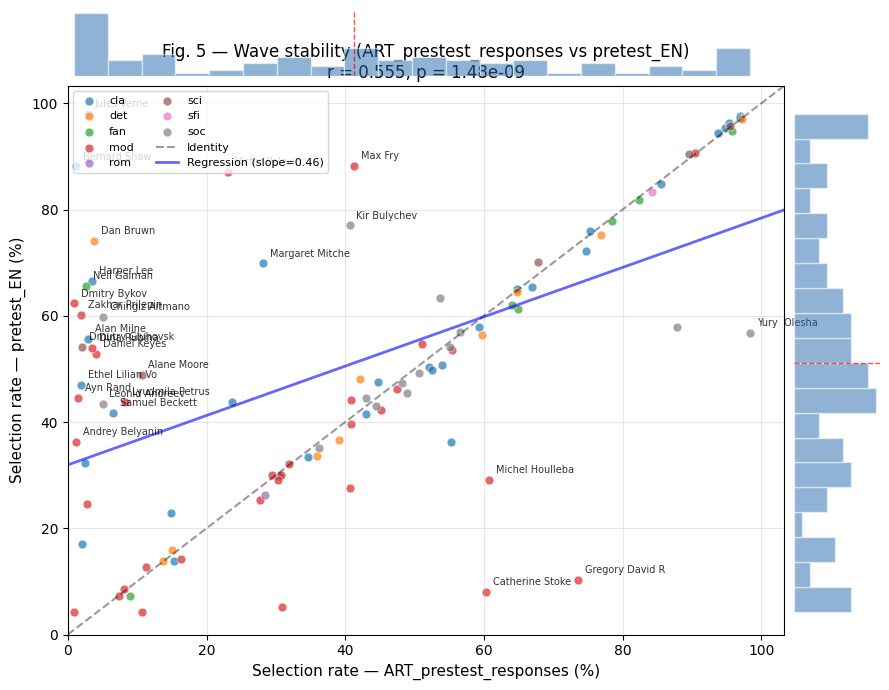

Saved: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/irt_art_results/Fig_5.png
  Outliers (|Δ| > 30%): 27 items
Mean standard_ART by wave: ART_prestest_responses=28.059, pretest_EN=47.600
Welch t-test (ART_prestest_responses vs pretest_EN): t=-24.016, p=0.00000

All-pairs wave stability:
                wave_a     wave_b  pearson_r  pearson_p  mean_abs_delta_pct  mean_delta_logit  sd_delta_logit
ART_prestest_responses pretest_EN    0.55451        0.0            16.67485           0.74888         1.87991
Saved: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/irt_art_results/wave_stability_pairwise.csv


In [25]:
# Cell 7 — Step 7: Genre analysis + wave stability (first-two and all-pairs)

from itertools import combinations
from scipy import stats

# Item-level summary for retained author items
item_summary = pd.DataFrame({
    "item_index": retained_author_idx,
    "author": [meta_by_idx.loc[i, "item_label"] for i in retained_author_idx],
    "item_code": [meta_by_idx.loc[i, "item_code"] for i in retained_author_idx],
    "genre": [meta_by_idx.loc[i, "genre"] for i in retained_author_idx],
    "pct_sel": [item_block.iloc[:, i].mean() * 100 for i in retained_author_idx],
    "a": a_params,
    "b": b_params,
})

genre_summary = item_summary.groupby("genre", dropna=False).agg(
    n_items=("author", "count"),
    mean_pct_sel=("pct_sel", "mean"),
    mean_a=("a", "mean"),
    sd_a=("a", "std"),
    mean_b=("b", "mean"),
    sd_b=("b", "std"),
).round(3).sort_values("mean_b")

genre_path = OUTPUT_DIR / "irt_parameters_by_genre.csv"
genre_summary.to_csv(genre_path)

print("=" * 80)
print("STEP 7a — IRT parameters by genre")
print("=" * 80)
print(genre_summary.to_string())
print(f"\nSaved: {genre_path}")

# One-way ANOVA on b and a across genres with >=2 items
valid_genres_b = [g for g, grp in item_summary.groupby("genre") if len(grp) >= 2]
if len(valid_genres_b) >= 2:
    groups_b = [item_summary.loc[item_summary["genre"] == g, "b"].values for g in valid_genres_b]
    F_b, p_b = stats.f_oneway(*groups_b)
    print(f"\nANOVA difficulty (b): F={F_b:.3f}, p={p_b:.5f}")
else:
    print("\nNot enough genres with >=2 items to run ANOVA on difficulty (b).")

valid_genres_a = [g for g, grp in item_summary.groupby("genre") if len(grp) >= 2]
if len(valid_genres_a) >= 2:
    groups_a = [item_summary.loc[item_summary["genre"] == g, "a"].values for g in valid_genres_a]
    F_a, p_a = stats.f_oneway(*groups_a)
    print(f"ANOVA discrimination (a): F={F_a:.3f}, p={p_a:.5f}")
else:
    print("Not enough genres with >=2 items to run ANOVA on discrimination (a).")

# Wave stability
waves = sorted(data[source_col].astype(str).dropna().unique().tolist())
print("\n" + "=" * 80)
print("STEP 7b — Wave stability")
print("=" * 80)
print(f"Waves found: {waves}")

if len(waves) >= 2:
    wave_rates = {}
    for w in waves:
        mask = data[source_col].astype(str) == w
        rates = item_block.iloc[mask.values, retained_author_idx].mean(axis=0) * 100
        wave_rates[w] = pd.Series(rates.values, index=retained_author_idx)
        print(f"Wave '{w}': N={int(mask.sum())}, mean author selection={rates.mean():.2f}%")

    # First-two waves (for direct comparability with prior script)
    w1, w2 = waves[0], waves[1]
    r12, p12 = stats.pearsonr(wave_rates[w1].values, wave_rates[w2].values)
    print(f"\nFirst-two wave correlation ({w1} vs {w2}): r={r12:.4f}, p={p12:.3e}")

    # Build plot data with genres for coloring
    plot_df = pd.DataFrame({
        "item_index": retained_author_idx,
        "x": wave_rates[w1].values,
        "y": wave_rates[w2].values,
        "genre": [meta_by_idx.loc[i, "genre"] for i in retained_author_idx],
        "author": [meta_by_idx.loc[i, "item_label"] for i in retained_author_idx],
    })
    plot_df["delta"] = plot_df["y"] - plot_df["x"]

    # Genre color palette
    unique_genres = sorted(plot_df["genre"].unique())
    palette = plt.cm.tab10.colors[:len(unique_genres)]
    genre_colors = {g: palette[i] for i, g in enumerate(unique_genres)}

    fig, ax = plt.subplots(figsize=(9, 7))

    # Scatter colored by genre
    for genre in unique_genres:
        mask = plot_df["genre"] == genre
        ax.scatter(plot_df.loc[mask, "x"], plot_df.loc[mask, "y"],
                   c=[genre_colors[genre]], alpha=0.7, s=40, label=genre, edgecolors="white", linewidths=0.5)

    # Identity line
    lim = max(plot_df["x"].max(), plot_df["y"].max()) * 1.05
    ax.plot([0, lim], [0, lim], "k--", alpha=0.4, lw=1.5, label="Identity")

    # Regression line
    slope, intercept = np.polyfit(plot_df["x"], plot_df["y"], 1)
    reg_x = np.array([0, lim])
    reg_y = slope * reg_x + intercept
    ax.plot(reg_x, reg_y, "b-", alpha=0.6, lw=2, label=f"Regression (slope={slope:.2f})")

    # Label outliers (|delta| > 30%)
    outliers = plot_df[np.abs(plot_df["delta"]) > 30]
    for _, row in outliers.iterrows():
        ax.annotate(row["author"][:15], xy=(row["x"], row["y"]),
                    xytext=(5, 5), textcoords="offset points", fontsize=7, alpha=0.8)

    ax.set_xlabel(f"Selection rate — {w1} (%)", fontsize=11)
    ax.set_ylabel(f"Selection rate — {w2} (%)", fontsize=11)
    ax.set_title(f"Fig. 5 — Wave stability ({w1} vs {w2})\nr = {r12:.3f}, p = {p12:.2e}", fontsize=12)
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left", fontsize=8, ncol=2)

    # Add marginal KDE using rugplot + histograms
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    ax_top = divider.append_axes("top", size="12%", pad=0.1, sharex=ax)
    ax_right = divider.append_axes("right", size="12%", pad=0.1, sharey=ax)

    # Top marginal (x distribution)
    ax_top.hist(plot_df["x"], bins=20, color=color_tif, alpha=0.5, edgecolor="white")
    ax_top.axvline(plot_df["x"].mean(), color="red", ls="--", lw=1, alpha=0.7)
    ax_top.set_xlim(0, lim)
    ax_top.axis("off")

    # Right marginal (y distribution)
    ax_right.hist(plot_df["y"], bins=20, color=color_tif, alpha=0.5, edgecolor="white", orientation="horizontal")
    ax_right.axhline(plot_df["y"].mean(), color="red", ls="--", lw=1, alpha=0.7)
    ax_right.set_ylim(0, lim)
    ax_right.axis("off")

    plt.tight_layout()
    fig5_path = OUTPUT_DIR / "fig_wave_stability.png"
    plt.savefig(fig5_path, dpi=200, bbox_inches="tight", facecolor="white")
    plt.show()
    print(f"Saved: {fig5_path}")
    print(f"  Outliers (|Δ| > 30%): {len(outliers)} items")

    t_stat, p_t = stats.ttest_ind(
        data.loc[data[source_col].astype(str) == w1, "standard_ART"],
        data.loc[data[source_col].astype(str) == w2, "standard_ART"],
        equal_var=False,
        nan_policy="omit",
    )
    print(f"Mean standard_ART by wave: {w1}={data.loc[data[source_col].astype(str) == w1, 'standard_ART'].mean():.3f}, {w2}={data.loc[data[source_col].astype(str) == w2, 'standard_ART'].mean():.3f}")
    print(f"Welch t-test ({w1} vs {w2}): t={t_stat:.3f}, p={p_t:.5f}")

    # All pairwise wave comparisons
    pair_rows = []
    def safe_logit_pct(pct):
        p = np.clip(np.asarray(pct) / 100.0, 0.001, 0.999)
        return np.log(p / (1 - p))

    for wa, wb in combinations(waves, 2):
        a_vals = wave_rates[wa].values
        b_vals = wave_rates[wb].values
        r, p = stats.pearsonr(a_vals, b_vals)
        logit_diff = safe_logit_pct(b_vals) - safe_logit_pct(a_vals)
        pair_rows.append({
            "wave_a": wa,
            "wave_b": wb,
            "pearson_r": r,
            "pearson_p": p,
            "mean_abs_delta_pct": float(np.mean(np.abs(b_vals - a_vals))),
            "mean_delta_logit": float(np.mean(logit_diff)),
            "sd_delta_logit": float(np.std(logit_diff)),
        })

    pairwise_df = pd.DataFrame(pair_rows).sort_values(["wave_a", "wave_b"]).round(5)
    pairwise_path = OUTPUT_DIR / "wave_stability_correlations.csv"
    pairwise_df.to_csv(pairwise_path, index=False)
    print("\nAll-pairs wave stability:")
    print(pairwise_df.to_string(index=False))
    print(f"Saved: {pairwise_path}")
else:
    print("Only one wave found; skipping wave stability analysis.")

In [26]:
# Cell 8 — Summary and output inventory

import glob

output_files = sorted(
    glob.glob(str(OUTPUT_DIR / "*.csv"))
    + glob.glob(str(OUTPUT_DIR / "*.png"))
)
output_files = list(dict.fromkeys(output_files))

print("=" * 90)
print("ALL OUTPUT FILES")
print("=" * 90)
for fp in output_files:
    size_kb = os.path.getsize(fp) / 1024
    print(f"{Path(fp).name:35s}  {size_kb:8.2f} KB")

print("\nAnalysis complete.")
print(f"Participants: {N}")
print(f"Total cleaned items: {len(item_labels)}")
print(f"Authors in metadata: {len(author_idx)}")
print(f"Foils in metadata: {len(foil_idx)}")
print(f"Retained authors after Step 2: {len(retained_author_idx)}")
print(f"Guessing items removed: {len(guessing_items)}")
print(f"Output directory: {OUTPUT_DIR}")

ALL OUTPUT FILES
Fig_1.png                              218.14 KB
Fig_2.png                              144.32 KB
Fig_3_score_correlations.png           120.15 KB
Fig_5.png                              241.97 KB
Table_1.csv                              0.59 KB
Table_1_initial.csv                      0.20 KB
Table_2.csv                              4.54 KB
Table_2_selection_rates.csv              3.65 KB
Table_3.csv                              4.37 KB
Table_4.csv                              8.30 KB
genre_comparison.csv                     0.33 KB
participant_scores.csv                 173.84 KB
wave_stability_pairwise.csv              0.15 KB

Analysis complete.
Participants: 1835
Total cleaned items: 205
Authors in metadata: 102
Foils in metadata: 103
Retained authors after Step 2: 102
Guessing items removed: 0
Output directory: /home/polina/Documents/Cursor_Projects/Russian Author Recognition Test Cursor/data/processed/irt_art_results
